# Control for Profile Size for Balanced Samples

This notebook looks at evaluation metrics controlled for profile size.

The `OutputAnalysis-Balanced` and `LastFMOutput-Balanced` notebooks must be run first.

## Setup

In [1]:
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
options(repr.plot.height=4.5, repr.matrix.max.rows=10)

In [3]:
source("plot-tools.R")

## Read Data

In [4]:
results = read_csv("build/integrated-user-results-balanced.csv")
results

Parsed with column specification:
cols(
  .default = col_character(),
  Partition = col_integer(),
  user = col_integer(),
  TestTime = col_double(),
  RMSE = col_double(),
  Rank.nDCG = col_double(),
  L100.nDCG = col_double(),
  L100.Rank = col_integer(),
  L100.RecipRank = col_double(),
  L100.AvgPrec = col_double(),
  TopN.ActualLength = col_double(),
  nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double(),
  occupation = col_integer(),
  nitems = col_integer()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,⋯,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,gender,age,occupation,zip,nitems
ML1M.GB,5,UU-E,4077,2.166,0.5989862,0.9908541,0.06519129,41,0.02439024,⋯,NA,NA,NA,NA,NA,F,35-44,2,22030,222
ML1M.GB,5,UU-E,4103,1.950,1.2600390,0.9702170,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,M,18-24,16,11211,141
ML1M.GB,5,UU-E,4109,1.723,0.8923990,0.9416146,0.05619730,63,0.01587302,⋯,NA,NA,NA,NA,NA,M,35-44,3,97202,20
ML1M.GB,5,UU-E,4119,1.820,1.0580385,0.9256552,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,M,50-55,1,39401,49
ML1M.GB,5,UU-E,4134,1.950,0.8821956,0.9497345,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,F,45-49,12,85283,113
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,1,II-B,2454,0.878,NA,0.9786268,0.46868978,1,1.0000000,⋯,1e4,1,1.0,0.5184497371894617,0.24517077241091578,M,18-24,NA,NA,54
LFM360K.GB,1,II-B,44667,0.833,NA,0.7707650,0.23238157,3,0.3333333,⋯,1e4,3,0.3333333333333333,0.2888431939610259,0.16810283096904824,M,18-24,NA,NA,58
LFM360K.GB,1,II-B,35706,0.808,NA,0.6387630,0.04326819,10,0.1000000,⋯,1e4,10,0.1,0.15105418949873792,0.03651757406042187,M,18-24,NA,NA,42
LFM360K.GB,1,II-B,11621,0.812,NA,0.9861884,0.48606784,1,1.0000000,⋯,1e4,1,1.0,0.5055258557033414,0.2581108620096556,F,18-24,NA,NA,43


## Explore Variables

There are two ways we can try to model: we can consider all algorithms, and just try to predict based on e.g. nratings. The other is that we can aggregate by user to produce a per-user 'difficulty' score. We will do the latter to avoid statistical non-independence problems.

In [5]:
user.metrics = results %>%
    group_by(DataSet, user, gender, age, nitems) %>%
    summarize(nDCG=mean(nDCG), AvgRR=mean(RecipRank))
user.metrics

DataSet,user,gender,age,nitems,nDCG,AvgRR
LFM360K.GB,1,F,18-24,44,0.1225371,0.01411803
LFM360K.GB,9,F,18-24,44,0.2361110,0.40488088
LFM360K.GB,16,M,18-24,42,0.1553259,0.01504073
LFM360K.GB,46,M,NA,57,0.1449091,0.06080028
LFM360K.GB,60,F,18-24,43,0.1489259,0.09727932
⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M.GB,6031,F,18-24,46,0.1463544,0.016601779
ML1M.GB,6035,F,25-34,275,0.1291621,0.004042766
ML1M.GB,6038,F,56+,15,0.1659413,0.029688640
ML1M.GB,6039,F,45-49,118,0.1636551,0.016925888


Let's plot to see what this is looking like:

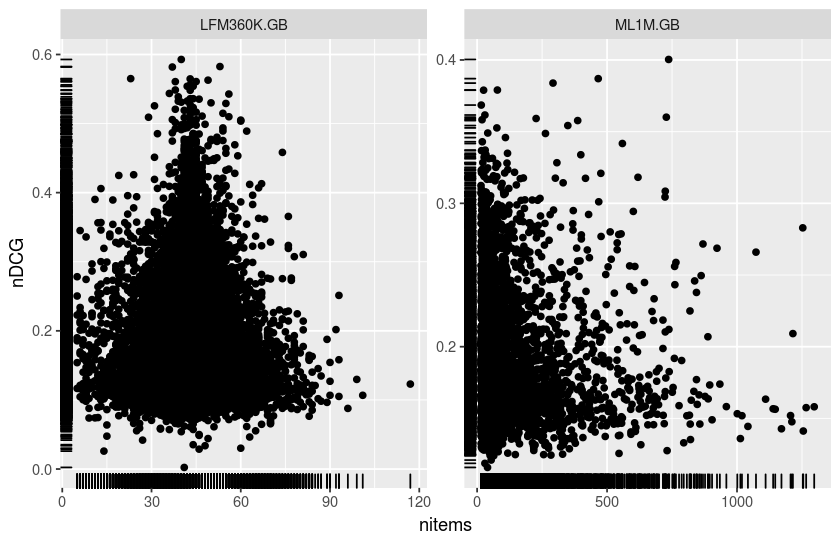

In [6]:
ggplot(user.metrics) +
    aes(x=nitems, y=nDCG) +
    geom_point() + 
    geom_rug() +
    facet_wrap(~ DataSet, scales="free")

Oof, that distribution is concentrated. Let's log the number of ratings, since log is often a good transform for counts:

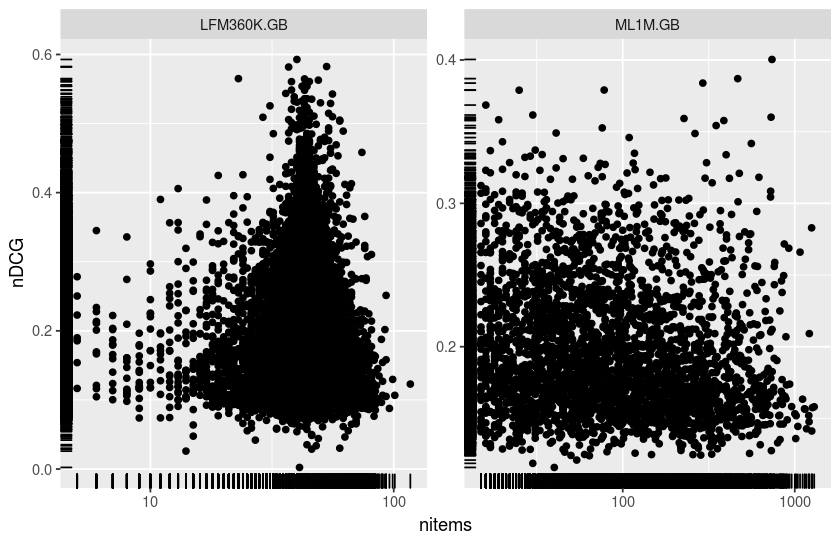

In [7]:
ggplot(user.metrics) +
    aes(x=nitems, y=nDCG) +
    geom_point() + 
    geom_rug() +
    scale_x_log10() +
    facet_wrap(~ DataSet, scales="free")

Looking better. Let's see how the difficulty (nDCG) is distributed (Q-Q plot):

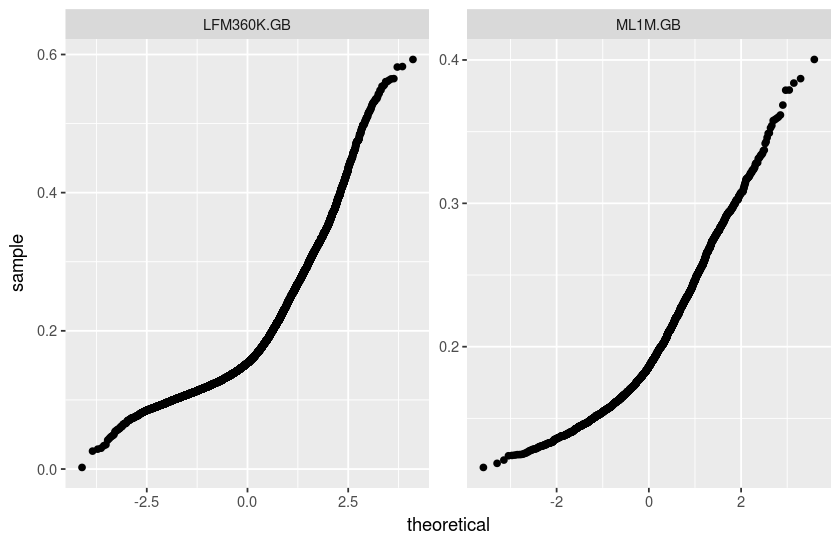

In [8]:
ggplot(user.metrics) +
    aes(sample=nDCG) +
    geom_qq() +
    facet_wrap(~ DataSet, scales='free')

That isn't quite normal; however, a log transform looks like it will be too aggressive. Let's try a square root:

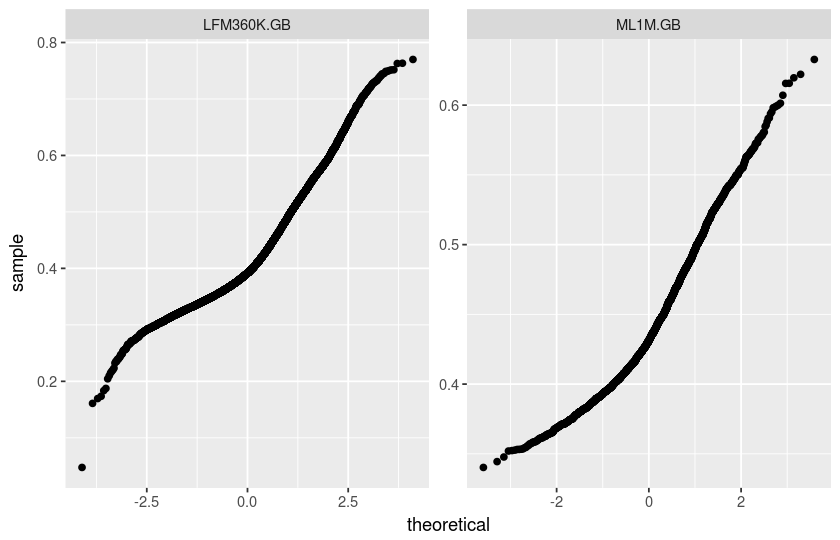

In [9]:
ggplot(user.metrics) +
    aes(sample=sqrt(nDCG)) +
    geom_qq() +
    facet_wrap(~ DataSet,scales='free')

Better. LFM1K isn't as good.

## Linear Modeling

We are going to build a linear model for each data set separately.

In [10]:
ml.ndcg.mod = lm(sqrt(nDCG) ~ log10(nitems), data=filter(user.metrics, DataSet == "ML1M.GB"))
summary(ml.ndcg.mod)


Call:
lm(formula = sqrt(nDCG) ~ log10(nitems), data = filter(user.metrics, 
    DataSet == "ML1M.GB"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10702 -0.03719 -0.01063  0.03209  0.20622 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.473517   0.003963 119.492  < 2e-16 ***
log10(nitems) -0.016389   0.001992  -8.229 2.77e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04966 on 2998 degrees of freedom
Multiple R-squared:  0.02209,	Adjusted R-squared:  0.02176 
F-statistic: 67.72 on 1 and 2998 DF,  p-value: 2.773e-16


In [11]:
lfm.ndcg.mod = lm(sqrt(nDCG) ~ log10(nitems), data=filter(user.metrics, DataSet == "LFM360K.GB"))
summary(lfm.ndcg.mod)


Call:
lm(formula = sqrt(nDCG) ~ log10(nitems), data = filter(user.metrics, 
    DataSet == "LFM360K.GB"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36451 -0.05422 -0.02005  0.04133  0.35772 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.436852   0.008248   52.96  < 2e-16 ***
log10(nitems) -0.015388   0.005046   -3.05  0.00229 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07496 on 24998 degrees of freedom
Multiple R-squared:  0.0003719,	Adjusted R-squared:  0.0003319 
F-statistic: 9.301 on 1 and 24998 DF,  p-value: 0.002293


Let's fill our data with these models.

We compute residuals manually, because we linear model residuals are in square-root space. For checking the model, we want:

$$\epsilon_i = \sqrt{\mathrm{nDCG}}-y_i$$

However, we also do want the _error_, which is

$$e_i = \mathrm{nDCG} - y_i^2$$

In [12]:
lfm.ndcg.preds = user.metrics %>%
    select(-AvgRR) %>%
    filter(DataSet == "LFM360K.GB") %>%
    add_predictions(lfm.ndcg.mod)
ml.ndcg.preds = user.metrics %>%
    select(-AvgRR) %>%
    filter(DataSet == "ML1M.GB") %>%
    add_predictions(ml.ndcg.mod)
ndcg.preds = bind_rows(lfm.ndcg.preds, ml.ndcg.preds) %>%
    rename(predRoot=pred) %>%
    mutate(pred = predRoot * predRoot, resid=sqrt(nDCG) - predRoot, error=nDCG-pred)
ndcg.preds

DataSet,user,gender,age,nitems,nDCG,predRoot,pred,resid,error
LFM360K.GB,1,F,18-24,44,0.1225371,0.4115627,0.1693839,-0.06150972,-0.04684677
LFM360K.GB,9,F,18-24,44,0.2361110,0.4115627,0.1693839,0.07434977,0.06672707
LFM360K.GB,16,M,18-24,42,0.1553259,0.4118736,0.1696399,-0.01775959,-0.01431401
LFM360K.GB,46,M,NA,57,0.1449091,0.4098328,0.1679629,-0.02916347,-0.02305378
LFM360K.GB,60,F,18-24,43,0.1489259,0.4117164,0.1695104,-0.02580724,-0.02058452
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M.GB,6031,F,18-24,46,0.1463544,0.4462661,0.1991535,-0.063703258,-0.052799108
ML1M.GB,6035,F,25-34,275,0.1291621,0.4335387,0.1879558,-0.074147480,-0.058793757
ML1M.GB,6038,F,56+,15,0.1659413,0.4542422,0.2063360,-0.046883210,-0.040394629
ML1M.GB,6039,F,45-49,118,0.1636551,0.4395609,0.1932138,-0.035017820,-0.029558683


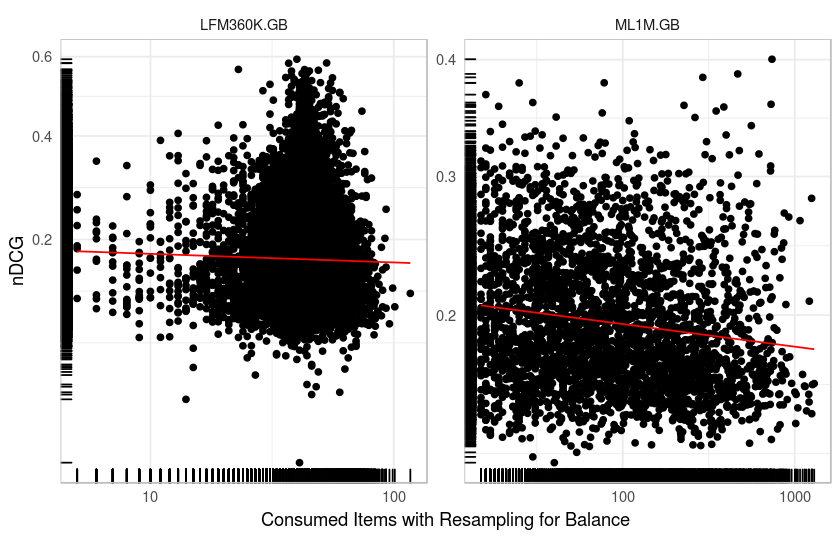

In [13]:
make.plot("balanced-linear-model-fit", width=5, height=2.5, {
    ggplot(ndcg.preds) +
        aes(x=nitems, y=nDCG) +
        geom_point() + 
        geom_line(mapping=aes(y=pred), color="red") +
        geom_rug() +
        scale_x_log10() + scale_y_sqrt() +
        facet_wrap(~ DataSet, scales="free") +
        theme_paper() +
        xlab("Consumed Items with Resampling for Balance")
})

Curiously, both of these have _negative_ slope.

## Controlled Gender Results

Now we want to control for the size of user's profile. Since male users rate more movies than female users, and long profiles are easier to predict for, it is possible that the increase in improvement for male users is due to rating size.

We will control for that by using our linear model for predicting 'difficulty' using profile size, and look at the remaining effect of gender on accuracy.

In [14]:
gender.corr.ndcg = results %>%
    select(DataSet, user, Algorithm, gender, nDCG) %>%
    inner_join(select(ndcg.preds, DataSet, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(DataSet, gender, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
gender.corr.ndcg

Adding missing grouping variables: `gender`, `age`
Joining, by = c("DataSet", "user", "gender")


DataSet,gender,Algorithm,nDCG,Corr.nDCG
LFM360K.GB,F,II-B,0.29524594,0.12564984
LFM360K.GB,F,II-C,0.08977526,-0.07982084
LFM360K.GB,F,II-CS,0.29668966,0.12709356
LFM360K.GB,F,MF-B,0.10322866,-0.06636744
LFM360K.GB,F,MF-C,0.09768407,-0.07191203
⋮,⋮,⋮,⋮,⋮
ML1M.GB,M,MF-B,0.1518031,-0.04287266
ML1M.GB,M,MF-E,0.1473357,-0.04734009
ML1M.GB,M,Pop-B,0.2323159,0.03764010
ML1M.GB,M,UU-B,0.3441450,0.14946919


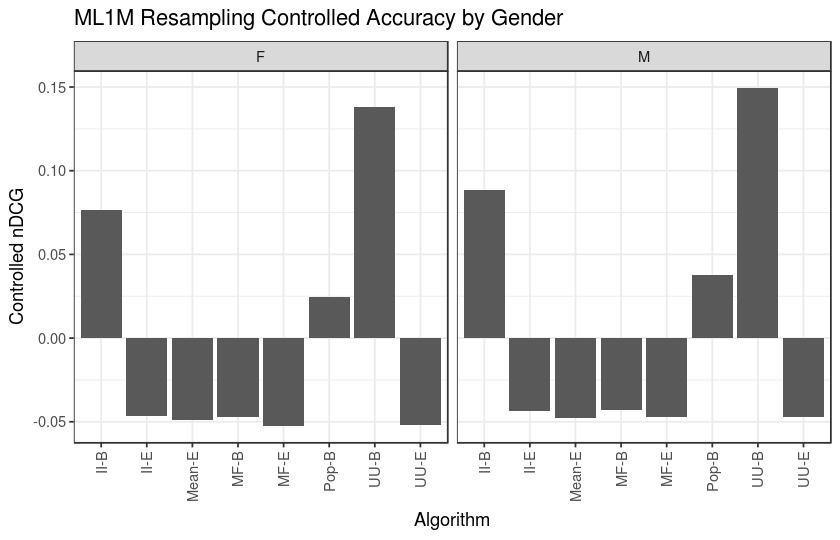

In [15]:
make.plot("balanced-controlled-gender-ndcg", width=5, height=2, {
    ggplot(gender.corr.ndcg %>% filter(DataSet == "ML1M.GB")) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge") +
        facet_grid(~ gender, scales="free") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG") +
        ggtitle("ML1M Resampling Controlled Accuracy by Gender")
})

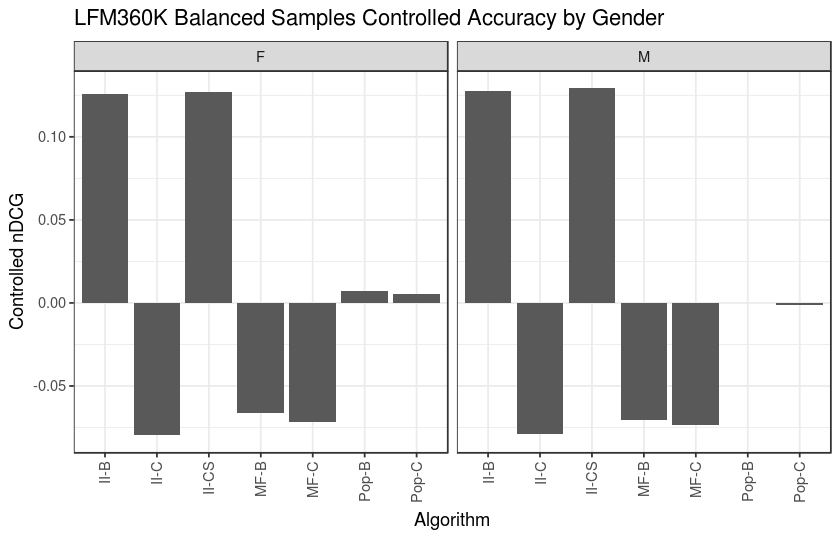

In [16]:
make.plot("balanced-controlled-gender-ndcg-lfm", width=5, height=2, {
    ggplot(gender.corr.ndcg %>% filter(DataSet == "LFM360K.GB")) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge") +
        facet_grid(~ gender, scales="free") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")  +
        ggtitle("LFM360K Balanced Samples Controlled Accuracy by Gender")
})

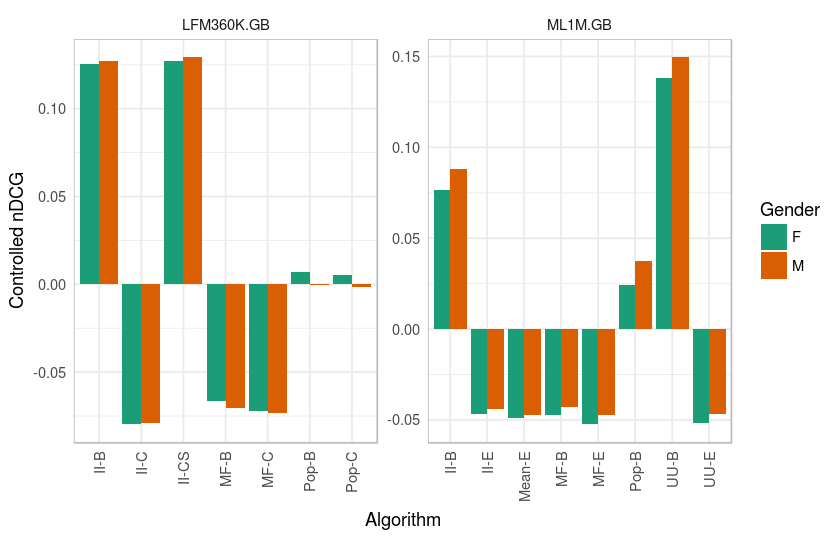

In [31]:
make.plot("controlled-gender-ndcg", width=5, height=2.5, {
    ggplot(gender.corr.ndcg %>% ungroup() %>% mutate(Gender=coalesce(gender, "Unknown"))) +
        aes(x=Algorithm, y=Corr.nDCG, fill=Gender) +
        geom_bar(stat="identity", position="dodge") +
        facet_wrap(~ DataSet, scales="free") +
        scale_fill_brewer(palette="Dark2") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

## kruskal test

compute corrected nDCG for each user in order to do a kruskal test

In [22]:
gender.corr.ndcg.per.user = results %>%
    select(DataSet, user, Algorithm, gender, nDCG) %>%
    inner_join(select(ndcg.preds, DataSet, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG)
gender.corr.ndcg.per.user

Adding missing grouping variables: `gender`, `age`
Joining, by = c("DataSet", "user", "gender")


DataSet,user,Algorithm,gender,nDCG,age,Pred.nDCG,Corr.nDCG
ML1M.GB,4077,UU-E,F,0.1678840,35-44,0.1892794,-0.02139539
ML1M.GB,4103,UU-E,M,0.1295478,18-24,0.1921011,-0.06255329
ML1M.GB,4109,UU-E,M,0.1611585,35-44,0.2044799,-0.04332137
ML1M.GB,4119,UU-E,M,0.1438356,50-55,0.1987523,-0.05491665
ML1M.GB,4134,UU-E,F,0.1430856,45-49,0.1934848,-0.05039926
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,2454,II-B,M,0.5184497,18-24,0.1682592,0.35019052
LFM360K.GB,44667,II-B,M,0.2888432,18-24,0.1678677,0.12097553
LFM360K.GB,35706,II-B,M,0.1510542,18-24,0.1696399,-0.01858570
LFM360K.GB,11621,II-B,F,0.5055259,18-24,0.1695104,0.33601548


filter out ML1M.GB data and the best algorithm UU-B for test

In [28]:
ml.gender.corr.ndcg = gender.corr.ndcg.per.user %>%
    filter(DataSet == 'ML1M.GB') %>%
    filter(Algorithm == 'UU-B') %>%
    mutate(gender=as.factor(gender))
ml.gender.corr.ndcg

DataSet,user,Algorithm,gender,nDCG,age,Pred.nDCG,Corr.nDCG
ML1M.GB,4077,UU-B,F,0.2039764,35-44,0.1892794,0.014697008
ML1M.GB,2192,UU-B,F,0.5673481,25-34,0.1933208,0.374027342
ML1M.GB,1165,UU-B,M,0.1774823,25-34,0.1923265,-0.014844179
ML1M.GB,4103,UU-B,M,0.1984590,18-24,0.1921011,0.006357849
ML1M.GB,2214,UU-B,F,0.4715689,25-34,0.1959765,0.275592393
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M.GB,3249,UU-B,F,0.2527621,25-34,0.1974691,0.05529305
ML1M.GB,3086,UU-B,M,0.1817967,18-24,0.1937683,-0.01197165
ML1M.GB,3263,UU-B,M,0.6557103,50-55,0.1937683,0.46194203
ML1M.GB,3093,UU-B,F,0.2288709,45-49,0.1907913,0.03807958


filter out LFM360K.GB data and the best algorithm II-CS for test

In [26]:
lfm.gender.corr.ndcg = gender.corr.ndcg.per.user %>%
    filter(DataSet == 'LFM360K.GB') %>%
    filter(Algorithm == 'II-CS') %>%
    mutate(gender=as.factor(gender))
lfm.gender.corr.ndcg

DataSet,user,Algorithm,gender,nDCG,age,Pred.nDCG,Corr.nDCG
LFM360K.GB,241257,II-CS,F,0.9042851,18-24,0.1690213,0.735263836
LFM360K.GB,241379,II-CS,M,0.6284422,25-34,0.1695104,0.458931857
LFM360K.GB,241418,II-CS,M,0.1594662,25-34,0.1687923,-0.009326118
LFM360K.GB,241591,II-CS,M,0.4867976,18-24,0.1691395,0.317658156
LFM360K.GB,238747,II-CS,M,0.2167042,25-34,0.1706451,0.046059157
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,2153,II-CS,F,0.1871233,18-24,0.1691395,0.01798380
LFM360K.GB,2316,II-CS,F,0.2332304,25-34,0.1661112,0.06711922
LFM360K.GB,2345,II-CS,M,0.4400303,18-24,0.1693839,0.27064637
LFM360K.GB,2407,II-CS,F,0.2754561,18-24,0.1696399,0.10581618


In [29]:
kruskal.test(nDCG ~ gender, ml.gender.corr.ndcg)


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 3.6614, df = 1, p-value = 0.05569


In [27]:
kruskal.test(nDCG ~ gender, lfm.gender.corr.ndcg)


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 0.13351, df = 1, p-value = 0.7148


## Controlled Age Results

In [32]:
age.corr.ndcg = results %>%
    filter(DataSet == "ML1M.GB") %>%
    select(user, Algorithm, age, nDCG) %>%
    inner_join(select(ndcg.preds, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(age, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(age.corr.ndcg)

Adding missing grouping variables: `DataSet`, `gender`, `age`
Joining, by = c("user", "age")


age,Algorithm,nDCG,Corr.nDCG
1-17,II-B,0.3025929,0.10677518
1-17,II-E,0.1422898,-0.05352796
1-17,Mean-E,0.1379685,-0.05784927
1-17,MF-B,0.1512451,-0.04457259
1-17,MF-E,0.1391705,-0.05664725
1-17,Pop-B,0.2211040,0.02528629


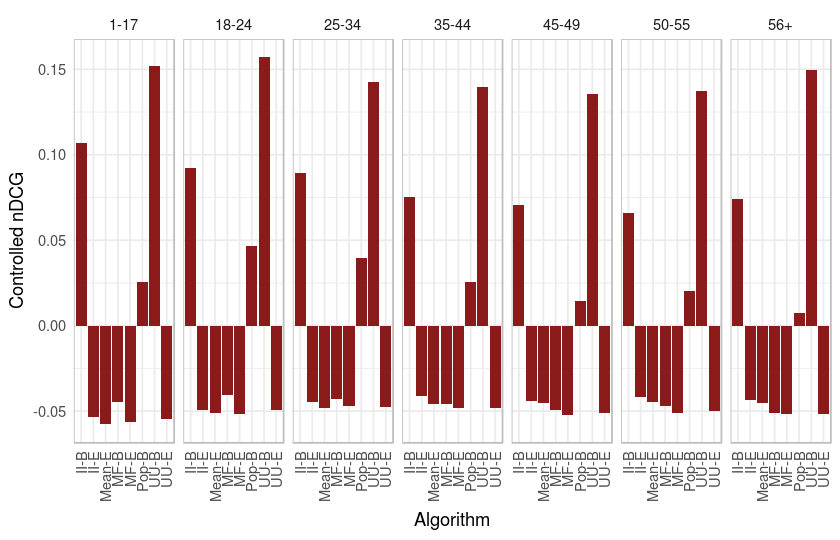

In [34]:
make.plot("controlled-age-ndcg-ml-balanced", width=5, height=2, {
    ggplot(age.corr.ndcg) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge", fill="firebrick4") +
        facet_grid(~ age, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

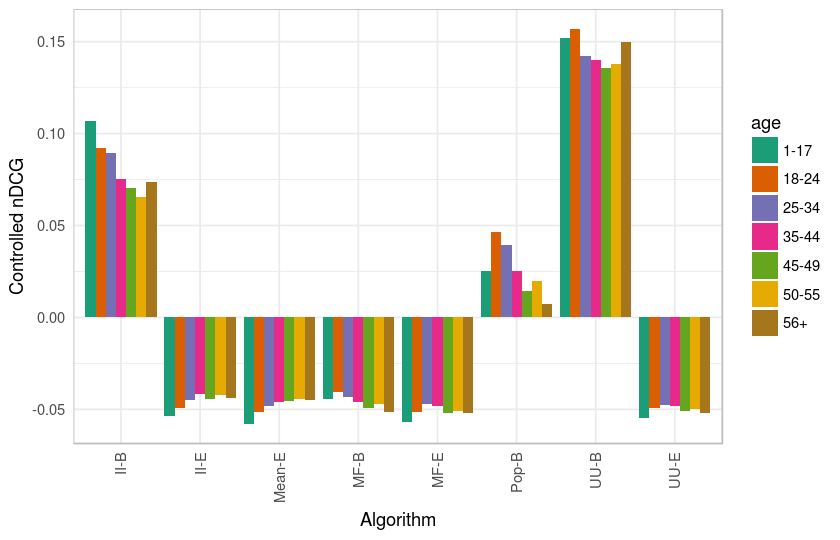

In [35]:
make.plot("controlled-age-ndcg-balanced", width=5, height=2, {
    ggplot(age.corr.ndcg) +
        aes(x=Algorithm, y=Corr.nDCG, fill=age) +
        geom_bar(stat="identity", position="dodge") +
        scale_fill_brewer(palette="Dark2") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

Discrepancy in performance is robust to controls for size.